In [1]:
# Copyright © 2022-​2024 ETH Zurich, Mattia Gollub; D-BSSE; CSB group

import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from typing import Callable
import random


plt.rcParams["font.family"] = "Helvetica"
group_palette = ["#926AAD", "#AFC286", "#B8772F", "#96BCE0"]
method_palette = ["#A64C4D", "#40609B"]
gray_palette = ["#AAAAAA"]
CAPSIZE = 0.05
ERRWIDTH = 1.5
DATA_DIR = pathlib.Path("../data")
RESULTS_DIR = pathlib.Path("../data/results")
FIGURES_DIR = pathlib.Path("../data/figures")
KM = r"$K_M$"
KCAT = r"$k_{cat}$"
GB = "GB"
BMM = "ENKIE"

type_order = [KM, KCAT]
groups_order = ["Measurement", "Protein", "Family", "Reaction"]
methods_order = [GB, BMM]

### Load validation data.

In [2]:
N_RMSE_SPLITS = 100
random.seed(42)


def norm_log_pdf(errors: np.ndarray, sds: np.ndarray | float) -> np.ndarray:
    var = np.square(sds)
    denom = np.sqrt(2 * np.pi * var)
    num = np.exp(-(errors**2) / (2 * var))
    return np.log(num / denom)


def rmse(errors: np.ndarray) -> float:
    return np.sqrt(np.mean(np.square(errors)))


def compare_nelpd(x: pd.DataFrame):
    nelpd_rmse = []
    nelpd_enkie = []
    for _ in range(N_RMSE_SPLITS):
        rmse_train_df = x.sample(frac=0.5)
        rmse_test_df = x.drop(rmse_train_df.index)
        rmse_train = rmse(rmse_train_df["error"])

        nelpd_rmse.append(-np.mean(norm_log_pdf(rmse_test_df["error"], rmse_train))),
        nelpd_enkie.append(
            -np.mean(norm_log_pdf(rmse_test_df["error"], rmse_test_df["pred_error"]))
        )
    return pd.Series(
        {
            "nelpd_rmse": np.mean(nelpd_rmse),
            "nelpd_enkie": np.mean(nelpd_enkie),
        }
    )


def compare_nelpd_nosplit(x: pd.DataFrame):
    if "training_rmse" in x.columns:
        x_rmse = x["training_rmse"].iloc[0]
    else:
        x_rmse = rmse(x["error"])
    return pd.Series(
        {
            "nelpd_rmse": -np.mean(norm_log_pdf(x["error"], x_rmse)),
            "nelpd_enkie": -np.mean(norm_log_pdf(x["error"], x["pred_error"])),
        }
    )


def make_stats_df(results_df: pd.DataFrame) -> pd.DataFrame:
    groups_df = results_df.groupby(["type", "grouping", "fold"])
    stats_df = groups_df.agg(
        rmse=("error", lambda x: np.sqrt(np.mean(x**2))),
        pred_rmse=("pred_error", lambda x: np.sqrt(np.mean(x**2))),
        nrmse=("err_ratio", lambda x: np.sqrt(np.mean(x**2))),
        uncertainty_error=("err_ratio", lambda x: (1 - np.sqrt(np.mean(x**2))) * 100),
    )
    stats_df["pearson"] = groups_df.apply(
        lambda x: pearsonr(x["value_log10"], x["pred_value"])[0]
    )
    stats_df["r2"] = groups_df.apply(
        lambda x: np.corrcoef(x["value_log10"], x["pred_value"])[0, 1] ** 2
    )
    stats_df = pd.concat([stats_df, groups_df.apply(compare_nelpd_nosplit)], axis=1)
    stats_df["nelpd_improvement"] = (
        (stats_df["nelpd_rmse"] - stats_df["nelpd_enkie"])
        / stats_df["nelpd_rmse"]
        * 100
    )

    stats_df = stats_df.reset_index()
    stats_df.replace({"type": {"km": KM, "kcat": KCAT}}, inplace=True)
    return stats_df

### Load random split data

In [3]:
test_dfs = []
for f in RESULTS_DIR.glob("*random*.csv"):
    if "residuals" in f.stem:
        continue
    _, grouping, fold = f.stem.split("_")
    df = pd.read_csv(f)
    df["grouping"] = grouping.capitalize()
    df["fold"] = int(fold)
    test_dfs.append(df)
test_df = pd.concat(test_dfs, ignore_index=True)

In [4]:
dfs = []
for f in RESULTS_DIR.glob("*.csv"):
    if "residuals" in f.stem:
        continue
    _, grouping, fold = f.stem.split("_")
    df = pd.read_csv(f)
    df["grouping"] = grouping.capitalize()
    df["fold"] = int(fold)
    dfs.append(df)
results_df = pd.concat(dfs, ignore_index=True)
results_df["err_ratio"] = results_df["error"] / results_df["pred_error"]
stats_df = make_stats_df(results_df)

/tmp/ipykernel_3728/3537168107.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_df["pearson"] = groups_df.apply(
/tmp/ipykernel_3728/3537168107.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_df["r2"] = groups_df.apply(
/tmp/ipykernel_3728/3537168107.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version o

In [5]:
stats_df.groupby(["type", "grouping"])[["nelpd_rmse", "nelpd_enkie"]].mean()

nelpd_rmse  nelpd_enkie
type      grouping                            
$K_M$     Family         1.392174     1.363953
          Measurement    1.053969     1.005886
          Protein        1.309320     1.261250
          Random         1.207327     1.132599
          Reaction       1.514817     1.510015
$k_{cat}$ Family         1.732146     1.734337
          Measurement    1.263936     1.232434
          Protein        1.635397     1.617594
          Random         1.481480     1.422556
          Reaction       1.813206     1.816601

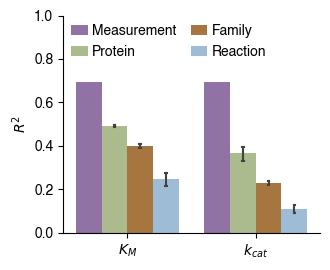

In [6]:
fig, folds_r2_ax = plt.subplots(figsize=(3.4, 2.8))

# Coefficient of determination with different splits.
sns.barplot(
    data=stats_df,
    x="type",
    y="r2",
    hue="grouping",
    ax=folds_r2_ax,
    palette=group_palette,
    order=type_order,
    hue_order=groups_order,
    capsize=CAPSIZE,
    err_kws={'linewidth': ERRWIDTH},
)
folds_r2_ax.set_xlabel("")
folds_r2_ax.set_ylim(0, 1.0)
folds_r2_ax.set_ylabel(r"$R^2$")
sns.move_legend(
    folds_r2_ax,
    "upper left",
    frameon=False,
    title=None,
    ncols=2,
    handlelength=1.2,
    handletextpad=0.3,
    columnspacing=1.0,
    borderpad=0.1,
)
sns.despine(ax=folds_r2_ax)

fig.tight_layout()
fig.savefig(FIGURES_DIR / "folds_r2.pdf", bbox_inches="tight")

In [7]:
def make_train_rmse_stats_df() -> pd.DataFrame:
    dfs = []
    for f in RESULTS_DIR.glob("*residuals.csv"):
        param_type, grouping, fold, _ = f.stem.split("_")
        df = pd.read_csv(f)
        df = np.abs(df[["Estimate"]])
        df["grouping"] = grouping.capitalize()
        df["fold"] = int(fold)
        df["type"] = param_type
        dfs.append(df)
    results_df = pd.concat(dfs, ignore_index=True)
    rmses_df = results_df.groupby(["type", "grouping", "fold"]).apply(
        lambda x: np.sqrt(np.mean(x["Estimate"] ** 2))
    )

    dfs = []
    for f in RESULTS_DIR.glob("*.csv"):
        if "residuals" in f.stem:
            continue
        _, grouping, fold = f.stem.split("_")
        df = pd.read_csv(f)
        df["grouping"] = grouping.capitalize()
        df["fold"] = int(fold)
        dfs.append(df)
    results_df = pd.concat(dfs, ignore_index=True)
    results_df["err_ratio"] = results_df["error"] / results_df["pred_error"]
    results_df = pd.merge(
        results_df,
        rmses_df.rename("training_rmse"),
        on=["type", "grouping", "fold"],
        how="left",
    )

    return make_stats_df(results_df)


train_rmse_stats_df = make_train_rmse_stats_df()

/tmp/ipykernel_3728/3915277640.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmses_df = results_df.groupby(["type", "grouping", "fold"]).apply(
/tmp/ipykernel_3728/3537168107.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_df["pearson"] = groups_df.apply(
/tmp/ipykernel_3728/3537168107.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depr

### Compute calibration curves

In [8]:
test_df["pred_error_rounded"] = test_df["pred_error"].apply(lambda x: round(x, 1))
calibration_all_df = (
    test_df.groupby(["type", "pred_error_rounded"])
        .aggregate({"error": lambda x: rmse(x), "pred_error": lambda x: rmse(x), "tissue": lambda x: len(x)})
        .reset_index()
        .rename(columns={"tissue": "n"})
        .replace({"km": KM, "kcat": KCAT})
)
# Exclude bins with low sample count.
calibration_all_df = calibration_all_df[calibration_all_df["n"] >= 100]

calibration_km_df = (
    test_df[test_df["type"] == "km"].groupby(["mnx_substrate_id"])
        .aggregate({"error": lambda x: rmse(x), "pred_error": lambda x: rmse(x), "tissue": lambda x: len(x)})
        .reset_index()
        .rename(columns={"tissue": "n"})
)
calibration_km_df = calibration_km_df[calibration_km_df["n"] >= 10]

calibration_kcat_df = (
    test_df[test_df["type"] == "kcat"].groupby(["mnx_reaction_id"])
    .aggregate({"error": lambda x: rmse(x), "pred_error": lambda x: rmse(x), "tissue": lambda x: len(x)})
    .reset_index()
    .rename(columns={"tissue": "n"})
)
calibration_kcat_df = calibration_kcat_df[calibration_kcat_df["n"] >= 10]
rmses_df = test_df.groupby("type").agg({"error": rmse}).rename(index={"km": KM, "kcat": KCAT})

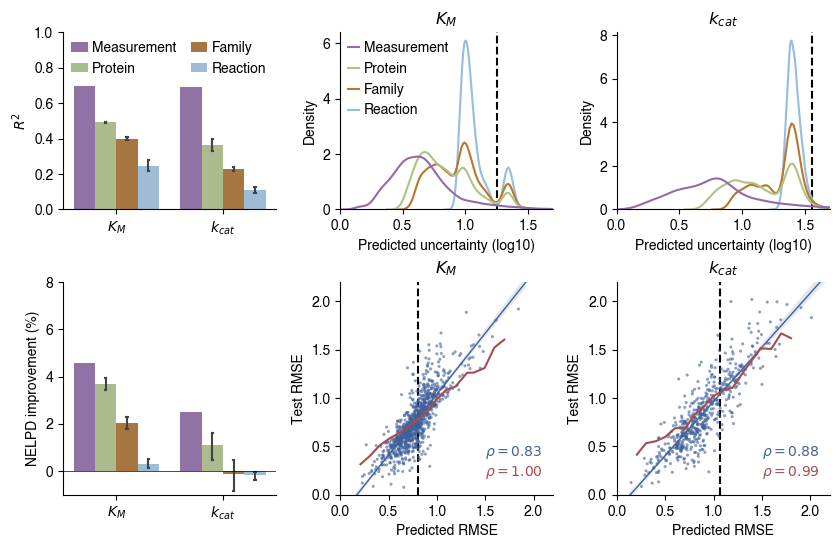

In [14]:
fig, (
    (folds_r2_ax, km_distribution_ax, kcat_distribution_ax),
    (nelpd_ax, calibration_km_ax, calibration_kcat_ax)
) = plt.subplots(2, 3, figsize=(8.5, 5.5), height_ratios=[1, 1.2])

# Coefficient of determination with different splits.
sns.barplot(
    data=stats_df,
    x="type",
    y="r2",
    hue="grouping",
    ax=folds_r2_ax,
    palette=group_palette,
    order=type_order,
    hue_order=groups_order,
    capsize=CAPSIZE,
    err_kws={'linewidth': ERRWIDTH},
)
folds_r2_ax.set_xlabel("")
folds_r2_ax.set_ylim(0, 1.0)
folds_r2_ax.set_ylabel(r"$R^2$")
sns.move_legend(
    folds_r2_ax,
    "upper left",
    frameon=False,
    title=None,
    ncols=2,
    handlelength=1.2,
    handletextpad=0.3,
    columnspacing=1.0,
    borderpad=0.1,
)
sns.despine(ax=folds_r2_ax)

# Distribution of prediction uncertainties with different splits.
km_distribution_ax.axvline(
    np.std(results_df[results_df["type"] == "km"]["value_log10"]),
    color="black",
    linestyle="--",
)
sns.kdeplot(
    data=results_df[results_df["type"] == "km"],
    x="pred_error",
    hue="grouping",
    ax=km_distribution_ax,
    hue_order=groups_order,
    palette=group_palette,
    common_norm=False,
)
km_distribution_ax.set_xlim(0, 1.7)
km_distribution_ax.set_title(KM)
km_distribution_ax.set_xlabel("Predicted uncertainty (log10)")
km_distribution_ax.get_legend().set_title("")
km_distribution_ax.get_legend().set_frame_on(False)
sns.move_legend(
    km_distribution_ax,
    "upper left",
    frameon=False,
    title=None,
    handlelength=0.8,
    handletextpad=0.3,
    borderpad=0.1,
)
sns.despine(ax=km_distribution_ax)

kcat_distribution_ax.axvline(
    np.std(results_df[results_df["type"] == "kcat"]["value_log10"]),
    color="black",
    linestyle="--",
)
sns.kdeplot(
    data=results_df[results_df["type"] == "kcat"],
    x="pred_error",
    hue="grouping",
    ax=kcat_distribution_ax,
    hue_order=groups_order,
    palette=group_palette,
    common_norm=False,
    legend=False,
)
kcat_distribution_ax.set_xlim(0, 1.7)
kcat_distribution_ax.set_title(KCAT)
kcat_distribution_ax.set_xlabel("Predicted uncertainty (log10)")
sns.despine(ax=kcat_distribution_ax)

# Evaluation of the uncertainties (test RMSE).
sns.barplot(
    data=stats_df,
    x="type",
    y="nelpd_improvement",
    hue="grouping",
    ax=nelpd_ax,
    palette=group_palette,
    order=type_order,
    hue_order=groups_order,
    capsize=CAPSIZE,
    err_kws={'linewidth': ERRWIDTH},
)
nelpd_ax.set_xlabel("")
nelpd_ax.set_ylabel("NELPD improvement (%)")
nelpd_ax.set_ylim(-1, 8)
nelpd_ax.get_legend().remove()
nelpd_ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
sns.despine(ax=nelpd_ax)

# Per-substrate uncertainty calilbration.
calibration_km_ax.axvline(x=rmses_df.loc[KM,:].iloc[0], color="black", linestyle="--", zorder=9)
sns.regplot(
    calibration_km_df,
    x="pred_error",
    y="error",
    truncate=False,
    color=method_palette[1],
    scatter_kws={
        "edgecolor": "none",
        "s": 5,
        "alpha": 0.6,
        "zorder":10
    },
    line_kws={
        "linewidth": 1,
        "zorder":11
    },
    ax=calibration_km_ax
)
calibration_param_df = calibration_all_df[calibration_all_df["type"] == KM]
sns.lineplot(
    calibration_param_df,
    x="pred_error",
    y="error",
    color=method_palette[0],
    zorder=12,
    ax=calibration_km_ax,
)
calibration_km_ax.set_xlim(0, 2.2)
calibration_km_ax.set_ylim(0, 2.2)
calibration_km_ax.set_aspect('equal')
calibration_km_ax.set_xlabel("Predicted RMSE")
calibration_km_ax.set_ylabel("Test RMSE")
calibration_km_ax.set_title(KM)
calibration_km_ax.text(1.5, 0.4, f'$\\rho={np.corrcoef(calibration_km_df["error"], calibration_km_df["pred_error"])[0, 1]:.2f}$', color=method_palette[1])
calibration_km_ax.text(1.5, 0.2, f'$\\rho={np.corrcoef(calibration_param_df["error"], calibration_param_df["pred_error"])[0, 1]:.2f}$', color=method_palette[0])
sns.despine(ax=calibration_km_ax)

# Per-substrate uncertainty calilbration.
calibration_kcat_ax.axvline(x=rmses_df.loc[KCAT,:].iloc[0], color="black", linestyle="--", zorder=9)
sns.regplot(
    calibration_kcat_df,
    x="pred_error",
    y="error",
    truncate=False,
    color=method_palette[1],
    scatter_kws={
        "edgecolor": "none",
        "s": 5,
        "alpha": 0.6,
        "zorder":10
    },
    line_kws={
        "linewidth": 1,
        "zorder":11
    },
    ax=calibration_kcat_ax
)
calibration_param_df = calibration_all_df[calibration_all_df["type"] == KCAT]
sns.lineplot(
    calibration_param_df,
    x="pred_error",
    y="error",
    color=method_palette[0],
    zorder=12,
    ax=calibration_kcat_ax,
)
calibration_kcat_ax.set_xlim(0, 2.2)
calibration_kcat_ax.set_ylim(0, 2.2)
calibration_kcat_ax.set_aspect('equal')
calibration_kcat_ax.set_xlabel("Predicted RMSE")
calibration_kcat_ax.set_ylabel("Test RMSE")
calibration_kcat_ax.set_title(KCAT)
calibration_kcat_ax.text(1.5, 0.4, f'$\\rho={np.corrcoef(calibration_kcat_df["error"], calibration_kcat_df["pred_error"])[0, 1]:.2f}$', color=method_palette[1])
calibration_kcat_ax.text(1.5, 0.2, f'$\\rho={np.corrcoef(calibration_param_df["error"], calibration_param_df["pred_error"])[0, 1]:.2f}$', color=method_palette[0])
sns.despine(ax=calibration_kcat_ax)

fig.tight_layout()
fig.savefig(FIGURES_DIR / "cv_results.pdf", bbox_inches="tight")

In [10]:
dfs = []
for f in (RESULTS_DIR / "kroll_2021").glob("*.csv"):
    _, fold = f.stem.split("_")
    df = pd.read_csv(f)
    df["type"] = KM
    df["fold"] = int(fold)
    dfs.append(df)
for f in (RESULTS_DIR / "kroll_2022").glob("*.csv"):
    _, fold = f.stem.split("_")
    df = pd.read_csv(f)
    df["type"] = KCAT
    df["fold"] = int(fold)
    dfs.append(df)
kroll_results_df = pd.concat(dfs, ignore_index=True)

groups_df = kroll_results_df.groupby(["type", "fold"])
kroll_comparison_df = (
    groups_df.apply(lambda x: pearsonr(x["value"], x["pred_value"])[0])
    .rename("pearson")
    .to_frame()
)
kroll_comparison_df["r2"] = groups_df.apply(
    lambda x: np.corrcoef(x["value"], x["pred_value"])[0, 1] ** 2
)
kroll_comparison_df = kroll_comparison_df.reset_index()
kroll_comparison_df["method"] = BMM
kroll_comparison_df = pd.concat(
    [
        kroll_comparison_df,
        pd.DataFrame(
            {
                "type": [KM, KCAT],
                "method": [GB, GB],
                "fold": [4, 4],
                "pearson": [np.nan, np.nan],
                "r2": [0.53, 0.44],
            }
        ),
    ]
)

kroll_comparison_df

/tmp/ipykernel_3728/2185717241.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups_df.apply(lambda x: pearsonr(x["value"], x["pred_value"])[0])
/tmp/ipykernel_3728/2185717241.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  kroll_comparison_df["r2"] = groups_df.apply(


type  fold   pearson        r2 method
0      $K_M$     0  0.669268  0.447920  ENKIE
1      $K_M$     1  0.683889  0.467704  ENKIE
2      $K_M$     2  0.664594  0.441686  ENKIE
3      $K_M$     3  0.684790  0.468938  ENKIE
4      $K_M$     4  0.678119  0.459845  ENKIE
5  $k_{cat}$     0  0.623984  0.389356  ENKIE
6  $k_{cat}$     1  0.614657  0.377803  ENKIE
7  $k_{cat}$     2  0.603919  0.364719  ENKIE
8  $k_{cat}$     3  0.579280  0.335565  ENKIE
9  $k_{cat}$     4  0.600266  0.360320  ENKIE
0      $K_M$     4       NaN  0.530000     GB
1  $k_{cat}$     4       NaN  0.440000     GB

In [11]:
# Load KM data.
km_test_df = pd.read_csv(RESULTS_DIR / "kroll_2021" / "km_4.csv")
kroll_km_test_df = pd.read_excel(
    DATA_DIR / "comparison_kroll_2021/Figure_4.xlsx",
    sheet_name="Figure 4 - panel c (blue dots)",
)
kroll_km_test_df.columns = ["predicted", "value"]
km_test_df["pred_kroll"] = kroll_km_test_df["predicted"]
km_test_df["error_kroll"] = np.abs(km_test_df["pred_kroll"] - km_test_df["value"])

# Load kcat data.
kcat_test_df = pd.read_csv(RESULTS_DIR / "kroll_2022" / "kcat_4.csv")
kcat_test_df["pred_kroll"] = np.load(
    DATA_DIR / "comparison_kroll_2022/y_test_pred_xgboost_ESM1b_ts_DRFP_mean.npy"
)
kcat_test_df["error_kroll"] = np.abs(kcat_test_df["pred_kroll"] - kcat_test_df["value"])


def compare_nelpd_kroll(
    df: pd.DataFrame, test_filter: Callable[[pd.DataFrame], pd.DataFrame] = lambda x: x
):
    nelpd_enkie = []
    nelpd_kroll = []
    for _ in range(N_RMSE_SPLITS):
        rmse_train_df = df.sample(frac=0.5)
        rmse_test_df = test_filter(df.drop(rmse_train_df.index))
        rmse_train_kroll = rmse(rmse_train_df["error_kroll"])

        nelpd_enkie.append(
            -np.mean(norm_log_pdf(rmse_test_df["error"], rmse_test_df["pred_error"]))
        )
        nelpd_kroll.append(
            -np.mean(norm_log_pdf(rmse_test_df["error_kroll"], rmse_train_kroll))
        )
    return pd.Series(
        {
            "nelpd_enkie": np.mean(nelpd_enkie),
            "nelpd_kroll": np.mean(nelpd_kroll),
        }
    )


nelpd_df = pd.concat(
    [
        compare_nelpd_kroll(km_test_df).rename(KM),
        compare_nelpd_kroll(kcat_test_df).rename(KCAT),
    ],
    axis=1,
)
nelpd_df.index.name = "method"
nelpd_df = nelpd_df.reset_index()
nelpd_df = nelpd_df.melt(id_vars="method", var_name="type", value_name="nelpd").replace(
    {"nelpd_enkie": BMM, "nelpd_kroll": GB}
)
nelpd_df

FileNotFoundError: [Errno 2] No such file or directory: '../data/comparison_kroll_2022/y_test_pred_xgboost_ESM1b_ts_DRFP_mean.npy'

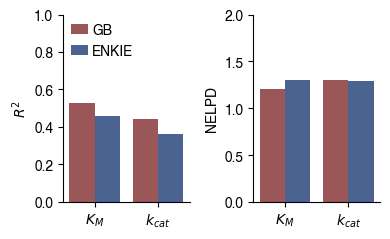

In [10]:
fig, (kroll_r2_ax, kroll_nelpd_ax) = plt.subplots(1, 2, figsize=(4, 2.5))

# Comparison with the Kroll papers.
sns.barplot(
    data=kroll_comparison_df[kroll_comparison_df["fold"] == 4],
    x="type",
    y="r2",
    hue="method",
    ax=kroll_r2_ax,
    palette=method_palette,
    order=type_order,
    hue_order=methods_order,
)
kroll_r2_ax.set_xlabel("")
kroll_r2_ax.set_ylim(0, 1.0)
kroll_r2_ax.set_ylabel(r"$R^2$")
sns.move_legend(
    kroll_r2_ax,
    "upper left",
    frameon=False,
    title=None,
    handlelength=1.2,
    handletextpad=0.3,
    borderpad=0.1,
)
sns.despine(ax=kroll_r2_ax)

sns.barplot(
    data=nelpd_df,
    x="type",
    y="nelpd",
    hue="method",
    ax=kroll_nelpd_ax,
    palette=method_palette,
    order=type_order,
    hue_order=methods_order,
)
kroll_nelpd_ax.set_xlabel("")
kroll_nelpd_ax.set_ylim(0, 2.0)
kroll_nelpd_ax.set_ylabel("NELPD")
kroll_nelpd_ax.get_legend().remove()
sns.despine(ax=kroll_nelpd_ax)

fig.tight_layout()